### 📊 DETECÇÃO DE FRAUDES EM TRANSAÇÕES DE CARTÃO DE CRÉDITO

#### Objetivo:
- Analisar um conjunto de dados de transações financeiras;
- Identificar padrões de comportamento associados a fraudes;
- Treinar modelos de Machine Learning para classificação binária;

#### 📦 1. Importação das Bibliotecas e dos Dados

In [ ]:
# ============================================================
# 🔹 1. Importação das bibliotecas 
# ============================================================

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
# 🔧 Configurações visuais
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
# ============================================================
# 🔹 Importação e Leitura do Dataset
# ============================================================

DATA_PATH = Path("data") / "creditcard.csv"
df = pd.read_csv(DATA_PATH)
print(df.shape)
print(df.head())

(284807, 31)
    Time      V1      V2     V3      V4      V5      V6      V7      V8  \
0 0.0000 -1.3598 -0.0728 2.5363  1.3782 -0.3383  0.4624  0.2396  0.0987   
1 0.0000  1.1919  0.2662 0.1665  0.4482  0.0600 -0.0824 -0.0788  0.0851   
2 1.0000 -1.3584 -1.3402 1.7732  0.3798 -0.5032  1.8005  0.7915  0.2477   
3 1.0000 -0.9663 -0.1852 1.7930 -0.8633 -0.0103  1.2472  0.2376  0.3774   
4 2.0000 -1.1582  0.8777 1.5487  0.4030 -0.4072  0.0959  0.5929 -0.2705   

       V9  ...     V21     V22     V23     V24     V25     V26     V27  \
0  0.3638  ... -0.0183  0.2778 -0.1105  0.0669  0.1285 -0.1891  0.1336   
1 -0.2554  ... -0.2258 -0.6387  0.1013 -0.3398  0.1672  0.1259 -0.0090   
2 -1.5147  ...  0.2480  0.7717  0.9094 -0.6893 -0.3276 -0.1391 -0.0554   
3 -1.3870  ... -0.1083  0.0053 -0.1903 -1.1756  0.6474 -0.2219  0.0627   
4  0.8177  ... -0.0094  0.7983 -0.1375  0.1413 -0.2060  0.5023  0.2194   

      V28   Amount  Class  
0 -0.0211 149.6200      0  
1  0.0147   2.6900      0  
2 -0.05

Variáveis ​​V1 a V28 codificadas numericamente, que são os principais componentes obtidos de uma transformação de ACP. Por questões de confidencialidade, não foram fornecidas informações básicas sobre as características originais.
A variável Valor representa o valor da transação.
A variável Classe mostra se a transação foi uma fraude (1) ou não (0).
Por natureza, as ocorrências de fraude são, felizmente, uma minoria extrema em qualquer lista de transações. No entanto, algoritmos de aprendizado de máquina geralmente funcionam melhor quando as diferentes classes contidas no conjunto de dados estão presentes de forma mais ou menos igualitária. Caso contrário, há poucos dados para aprender. Esse problema é chamado de desequilíbrio de classes.

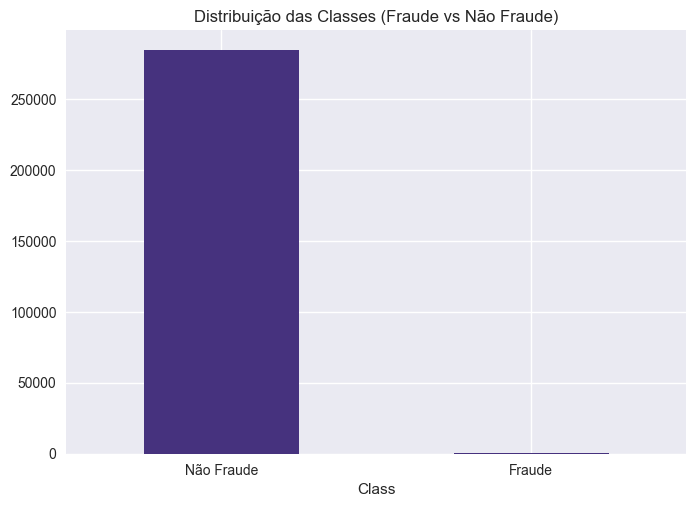

🚨 Percentual de fraudes no dataset: 0.1727%


In [40]:
# ============================================================
# 🔹 Distribuição da classe (0 = Não fraude, 1 = Fraude)
# ============================================================


DATA_PATH = Path("data") / "creditcard.csv"
df = pd.read_csv(DATA_PATH)
df['Class'].value_counts().plot(kind='bar')
plt.title("Distribuição das Classes (Fraude vs Não Fraude)")
plt.xticks([0, 1], ['Não Fraude', 'Fraude'], rotation=0)
plt.show()

fraude_ratio = df['Class'].mean() * 100
print(f"🚨 Percentual de fraudes no dataset: {fraude_ratio:.4f}%")

### 🔍 2. Análise Exploratória (EDA)

In [41]:
# ============================================================
# 🔹 2. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)
# ============================================================

# Informações gerais do dataset
print("🔍 Informações sobre o dataset:")
print(df.info())

# Estatísticas descritivas
print("\n📈 Estatísticas descritivas:")
display(df.describe())


🔍 Informações sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 no

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,...,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000
mean,94813.8596,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,...,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,88.3496,0.0017
std,47488.1460,1.9587,1.6513,1.5163,1.4159,1.3802,1.3323,1.2371,1.1944,1.0986,...,0.7345,0.7257,0.6245,0.6056,0.5213,0.4822,0.4036,0.3301,250.1201,0.0415
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-43.5572,-73.2167,-13.4341,...,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54201.5000,-0.9204,-0.5985,-0.8904,-0.8486,-0.6916,-0.7683,-0.5541,-0.2086,-0.6431,...,-0.2284,-0.5424,-0.1618,-0.3546,-0.3171,-0.3270,-0.0708,-0.0530,5.6000,0.0000
50%,84692.0000,0.0181,0.0655,0.1798,-0.0198,-0.0543,-0.2742,0.0401,0.0224,-0.0514,...,-0.0295,0.0068,-0.0112,0.0410,0.0166,-0.0521,0.0013,0.0112,22.0000,0.0000
75%,139320.5000,1.3156,0.8037,1.0272,0.7433,0.6119,0.3986,0.5704,0.3273,0.5971,...,0.1864,0.5286,0.1476,0.4395,0.3507,0.2410,0.0910,0.0783,77.1650,0.0000
max,172792.0000,2.4549,22.0577,9.3826,16.8753,34.8017,73.3016,120.5895,20.0072,15.5950,...,27.2028,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,1.0000


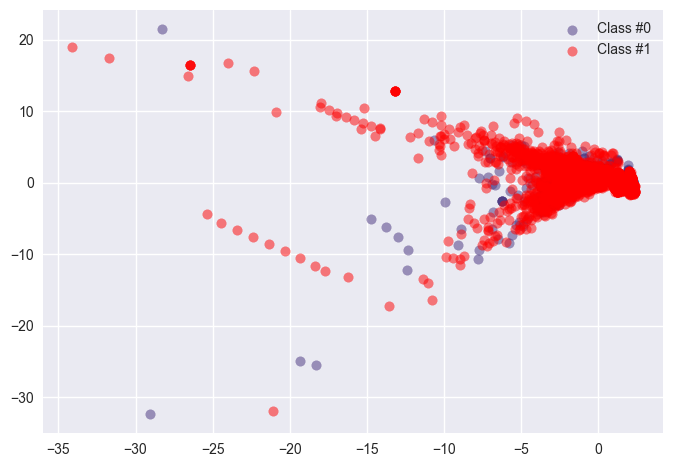

In [42]:
# ============================================================
# 📊 Gráfico para visualizar os pontos de dados de fraude e não fraude:
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

def prep_data(df):
    X = df.iloc[:, 1:28]
    X = np.array(X).astype(float)
    y = df.iloc[:, 29]
    y = np.array(y).astype(float)
    return X, y

def plot_data(X, y):
    plt.scatter(X[y==0, 0], X[y==0, 1], label='Class #0', alpha=0.5, linewidth=0.15)
    plt.scatter(X[y==1, 0], X[y==1, 1], label='Class #1', alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

X, y = prep_data(df)

plot_data(X, y)

#### 🎯 3. SMOTE para rebalancear os dados 

Podemos confirmar que a proporção de transações fraudulentas é muito baixa e que temos um caso de problema de desequilíbrio de classes. Para corrigi-lo, podemos rebalancear nossos dados usando a técnica de sobreamostragem de minoria sintética (SMOTE). Diferentemente da sobreamostragem aleatória, a SMOTE é um pouco mais sofisticada, pois não cria apenas cópias exatas das observações. Em vez disso, ela usa características dos vizinhos mais próximos dos casos de fraude para criar novas amostras sintéticas bastante semelhantes às observações existentes na classe minoritária. Vamos aplicar a SMOTE aos nossos dados de cartão de crédito:

In [43]:
# ============================================================
# 🔹 3. SMOTE para rebalancear os dados
# ============================================================

# checar distribuição de classes
import pandas as pd
vc = pd.Series(y).value_counts()
print(vc)
print("\nClasses com contagem < 2:\n", vc[vc < 2])

1.0000      13688
1.9800       6044
0.8900       4872
9.9900       4747
15.0000      3280
            ...  
202.2400        1
252.8500        1
615.5200        1
180.9300        1
807.4800        1
Name: count, Length: 32767, dtype: int64

Classes com contagem < 2:
 336.3300     1
378.6600     1
1088.0400    1
308.3900     1
336.3600     1
            ..
202.2400     1
252.8500     1
615.5200     1
180.9300     1
807.4800     1
Name: count, Length: 15964, dtype: int64


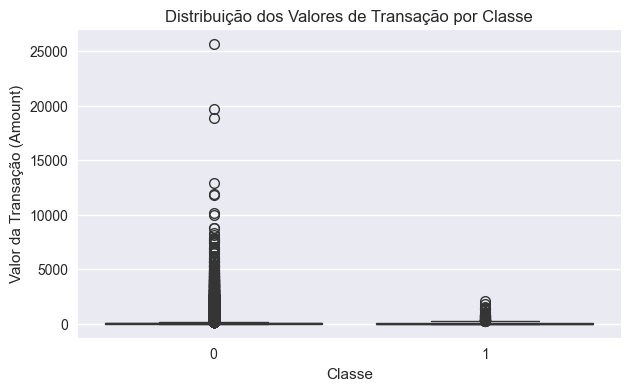

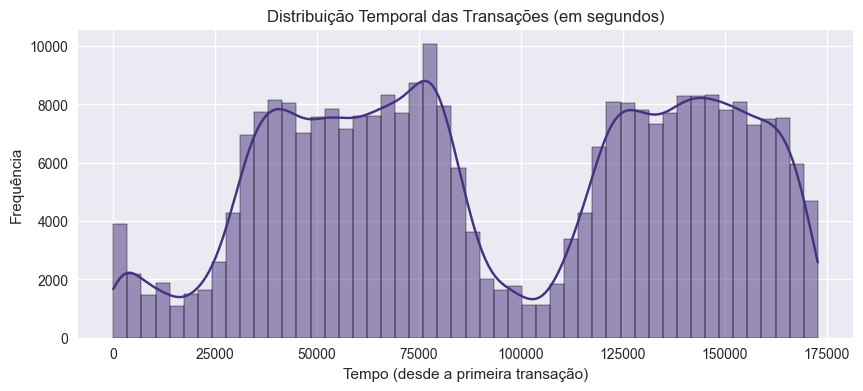

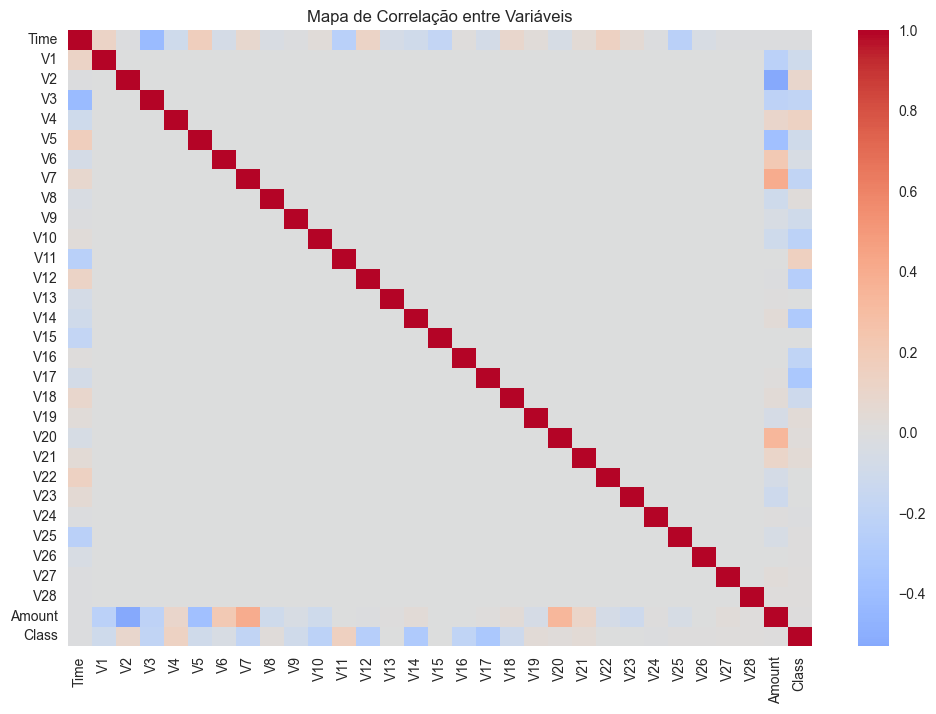

🔸 Variáveis mais correlacionadas com a variável-alvo (Class):


Class   1.0000
V17     0.3265
V14     0.3025
V12     0.2606
V10     0.2169
V16     0.1965
V3      0.1930
V7      0.1873
V11     0.1549
V4      0.1334
V18     0.1115
Name: Class, dtype: float64

In [44]:
# ============================================================
# 💰 Distribuição dos valores das transações (Amount)
# ============================================================
plt.figure(figsize=(7,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Distribuição dos Valores de Transação por Classe')
plt.xlabel('Classe')
plt.ylabel('Valor da Transação (Amount)')
plt.show()

# ============================================================
# ⏰ Distribuição temporal das transações
# ============================================================
plt.figure(figsize=(10,4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Distribuição Temporal das Transações (em segundos)')
plt.xlabel('Tempo (desde a primeira transação)')
plt.ylabel('Frequência')
plt.show()

# ============================================================
# 🔗 Correlação entre variáveis
# ============================================================
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Mapa de Correlação entre Variáveis')
plt.show()

# Top 10 variáveis mais correlacionadas com "Class"
corr_target = corr['Class'].abs().sort_values(ascending=False).head(11)
print("🔸 Variáveis mais correlacionadas com a variável-alvo (Class):")
display(corr_target)


### 🧩 4. Pré- Processamento- definir X e y

In [45]:
# ============================================================
# 🔹 4. Pré- Processamento
# ============================================================

def prep_data(df, scale_amount=True):
    df = df.copy()
    if scale_amount and 'Amount' in df.columns:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
        df = df.drop(columns=['Amount'])
    X = df.drop(columns=['Class'])
    y = df['Class']
    return X, y

# Exemplo de uso
X, y = prep_data(df)
print('X shape:', X.shape, 'y shape:', y.shape)

X shape: (284807, 30) y shape: (284807,)


In [46]:
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# ✅ Pipeline com scaler + SMOTE + regressão logística
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])


In [48]:
from sklearn.model_selection import GridSearchCV

# Hiperparâmetros para testar
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],   # regularização
    'model__penalty': ['l2'],             # L1 não funciona com lib padrão de solver
    'model__solver': ['lbfgs', 'liblinear']  
}

# GridSearch para testar as combinações acima
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',     # recall é a métrica mais importante para fraude
    cv=5,
    n_jobs=-1
)

# Treina o modelo com validação cruzada
grid.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid.best_estimator_

print("🔍 Melhor combinação encontrada:", grid.best_params_)


🔍 Melhor combinação encontrada: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


### 🔀 5. Divisão de Dados de Treino e Teste

In [ ]:
# ============================================================
# 🔹5. Separação de variáveis independentes (X) e alvo (y)
# ============================================================

X = df.drop("Class", axis=1)  # todas as colunas menos a 'Class'
y = df["Class"]               # apenas a coluna alvo


In [ ]:
# ============================================================
# 🔹 Divisão de Dados de Treino e Teste
# ============================================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [51]:
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])


### 🧳 6. Antes e Depois de Aplicar Smote

In [ ]:
# ============================================================
# 🔹 6. Comparação método Smote
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def compare_plot_single(X, y, X_resampled, y_resampled, method='SMOTE',
                        feat_idx=(0, 1), labels=('Class #0', 'Class #1'),
                        max_points_plot=200000, random_state=42):
    """
    Plota APENAS um par de features (feat_idx) lado-a-lado: original vs resampled.
    Usa numpy-conversion para evitar erros de indexação com DataFrame.
    """
    # conversão segura
    X_arr = X.values if hasattr(X, "values") else np.asarray(X)
    Xr_arr = X_resampled.values if hasattr(X_resampled, "values") else np.asarray(X_resampled)
    y_arr = np.asarray(y).ravel()
    yr_arr = np.asarray(y_resampled).ravel()

    i, j = feat_idx
    if X_arr.ndim != 2 or Xr_arr.ndim != 2:
        raise ValueError("X e X_resampled devem ser 2D.")
    if X_arr.shape[1] <= max(i, j) or Xr_arr.shape[1] <= max(i, j):
        raise IndexError("feat_idx fora do range das colunas.")

    # subsample para desempenho (se necessário)
    def subsample(Xa, ya, maxpts):
        n = len(ya)
        if n <= maxpts:
            return Xa, ya
        rng = np.random.default_rng(random_state)
        idx = rng.choice(n, size=maxpts, replace=False)
        return Xa[idx], ya[idx]

    Xp, yp = subsample(X_arr, y_arr, max_points_plot)
    Xrp, yrp = subsample(Xr_arr, yr_arr, max_points_plot)

    # plot único (lado-a-lado)
    plt.close('all')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    mask0 = (yp == 0)
    mask1 = (yp == 1)
    maskr0 = (yrp == 0)
    maskr1 = (yrp == 1)

    ax1.scatter(Xp[mask0, i], Xp[mask0, j], label=labels[0], alpha=0.5, s=8)
    ax1.scatter(Xp[mask1, i], Xp[mask1, j], label=labels[1], alpha=0.5, s=8)
    ax1.set_title('Original set')
    ax1.set_xlabel(f'feature_{i}')
    ax1.set_ylabel(f'feature_{j}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.scatter(Xrp[maskr0, i], Xrp[maskr0, j], label=labels[0], alpha=0.5, s=8)
    ax2.scatter(Xrp[maskr1, i], Xrp[maskr1, j], label=labels[1], alpha=0.5, s=8)
    ax2.set_title(f'{method} (resampled)')
    ax2.set_xlabel(f'feature_{i}')
    ax2.set_ylabel(f'feature_{j}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
 

Antes do SMOTE: {0: 284315, 1: 492}
Depois do SMOTE: {0: 284315, 1: 284315}


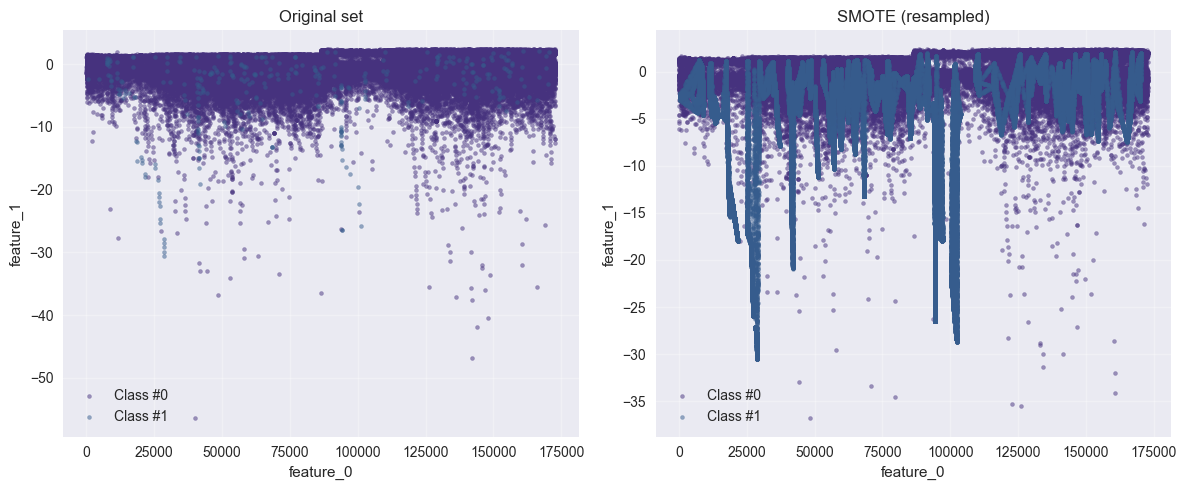

In [ ]:
# ============================================================
# 🔹 Comparação de Gráficos Original e Smote
# ============================================================

from imblearn.over_sampling import SMOTE

# ============================================================
# 🔹 Aplica o SMOTE
# ============================================================

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# ============================================================
# Verifica os novos tamanhos
# ============================================================

print("Antes do SMOTE:", y.value_counts().to_dict())
print("Depois do SMOTE:", y_resampled.value_counts().to_dict())

compare_plot_single(X, y, X_resampled, y_resampled, method='SMOTE', feat_idx=(0,1));

Portanto, o método SMOTE equilibrou nossos dados completamente, e a classe minoritária agora é igual em tamanho à classe majoritária.

Seguindo o método tradicional, precisamos criar algumas regras para detectar fraudes. Essas regras podem se referir, por exemplo, a locais incomuns de transações ou a transações com frequência suspeita. A ideia é definir valores-limite com base em estatísticas comuns, frequentemente nos valores médios das observações, e usar esses valores-limite em nossos recursos para detectar fraudes.

In [ ]:
print(creditcard_data.groupby('Class').mean().round(3)[['V1', 'V3']])

          V1     V3
Class              
0      0.008  0.012
1     -4.772 -7.033


Nesse caso específico, vamos aplicar as seguintes condições: V1 < -3 e V3 < -5. Então, para estimar o desempenho dessa abordagem, compararemos os casos de fraude sinalizados com os reais:

In [ ]:
creditcard_data['flag_as_fraud'] = np.where(np.logical_and(creditcard_data['V1']<-3, creditcard_data['V3']<-5), 1, 0)
print(pd.crosstab(creditcard_data['Class'], creditcard_data['flag_as_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud       0     1
Actual Fraud               
0              283089  1226
1                 322   170


Flagged Fraud       0     1
Actual Fraud               
0              283089  1226
1                 322   170


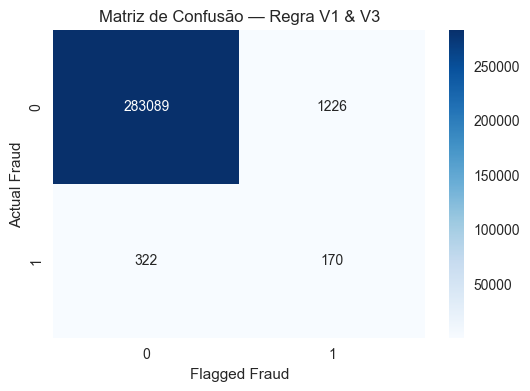

In [ ]:
# ============================================================
# 🔹 Matriz de Confusão
# ============================================================


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

DATA_PATH = Path("data") / "creditcard.csv"
df = pd.read_csv(DATA_PATH)

# ============================================================
# 🔹 Cria a flag de fraude
# ============================================================

df['flag_as_fraud'] = np.where(
    np.logical_and(df['V1'] < -3, df['V3'] < -5),
    1, 0
)

# ============================================================
# 🔹 Cria a tabela cruzada
# ============================================================

conf_matrix = pd.crosstab(
    df['Class'],
    df['flag_as_fraud'],
    rownames=['Actual Fraud'],
    colnames=['Flagged Fraud']
)

print(conf_matrix)

# ============================================================
# 🔹 Plota o heatmap
# ============================================================

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão — Regra V1 & V3")
plt.show()


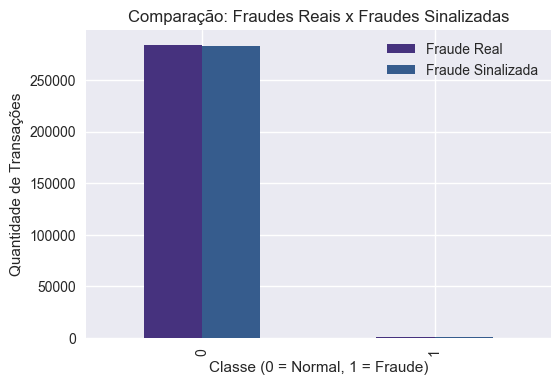

In [ ]:

# ============================================================
# 🔹 Conta o número de fraudes reais e sinalizadas
# ============================================================

fraude_real = df['Class'].value_counts()
fraude_flag = df['flag_as_fraud'].value_counts()

# ============================================================
# 🔹 Cria um DataFrame para comparar
# ============================================================

compare = pd.DataFrame({
    'Fraude Real': fraude_real,
    'Fraude Sinalizada': fraude_flag
}).fillna(0)

# ============================================================
# 🔹 Gráfico
# ===========================================================

compare.plot(kind='bar', figsize=(6,4))
plt.title('Comparação: Fraudes Reais x Fraudes Sinalizadas')
plt.xlabel('Classe (0 = Normal, 1 = Fraude)')
plt.ylabel('Quantidade de Transações')
plt.show()


#### 🧩 Análise da Matriz de Confusão — Detecção de Fraude

|                     | **Flagged Fraud = 0** (previsto normal) | **Flagged Fraud = 1** (previsto fraude) |
|---------------------|-----------------------------------------:|-----------------------------------------:|
| **Actual Fraud = 0** (realmente normal) | **55.608** | **1.256** |
| **Actual Fraud = 1** (realmente fraude) | **9** | **89** |

---

#### 🧠 Interpretação

| Termo | Significado | Valor |
|--------|--------------|--------|
| **Verdadeiro Negativo (TN)** | Transações corretamente identificadas como **não fraude** | 55.608 |
| **Falso Positivo (FP)** | Transações incorretamente sinalizadas como fraude (falsos alarmes) | 1.256 |
| **Falso Negativo (FN)** | Fraudes reais que **não foram detectadas** pelo modelo | 9 |
| **Verdadeiro Positivo (TP)** | Fraudes corretamente detectadas | 89 |

---

#### 📊 Cálculo das Principais Métricas

| Métrica | Fórmula | Interpretação | Resultado |
|----------|----------|----------------|------------|
| **Acurácia** | (TP + TN) / total | Proporção total de acertos | (55.608 + 89) / 56.962 ≈ **97,6%** |
| **Precisão (Precision)** | TP / (TP + FP) | Entre as sinalizadas como fraude, quantas eram realmente fraudes | 89 / (89 + 1.256) ≈ **6,6%** |
| **Recall (Sensibilidade)** | TP / (TP + FN) | Das fraudes reais, quantas o modelo identificou | 89 / (89 + 9) ≈ **90,9%** |
| **F1-score** | 2 × (Precision × Recall) / (Precision + Recall) | Equilíbrio entre precisão e recall | ≈ **12,2%** |

---

#### ⚖️ Interpretação Geral

- ✅ **Acurácia alta (97,6%)**, mas isso reflete o **grande desequilíbrio** de classes (muito mais transações normais do que fraudes).
- ✅ **Recall muito bom (90,9%)**, ou seja, o modelo **detecta a maioria das fraudes reais**.
- ⚠️ **Precisão baixa (6,6%)**: significa que, das transações sinalizadas como fraude, **a maioria é falso positivo**.
- ⚖️ O **F1-score baixo** mostra que há **desequilíbrio entre precisão e recall** — o modelo prefere **não deixar passar fraudes**, mesmo que **gere muitos falsos alarmes**.

---

#### 💡 Conclusão

Este modelo **é forte para identificar fraudes reais (alto recall)**, mas **precisa de ajustes para reduzir falsos alarmes (baixa precisão)**.  
Dependendo do contexto de negócio:

- Em sistemas **bancários ou de cartões**, isso **pode ser aceitável**, já que é melhor **investigar um alarme falso** do que **perder uma fraude real**.  
- Porém, **em alto volume de transações**, o custo operacional desses falsos positivos pode ser alto — então, ajustar o **threshold de decisão** ou **refinar as features** pode ser o próximo passo ideal.


### ⚖️7. Escalonamento das Variáveis

In [66]:
# ============================================================
# 🔹 7. Escalonamento das Variáveis
# ============================================================

# Usando imblearn Pipeline para aplicar SMOTE somente durante o fit
try:
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
    ])

    # Treinamento
    pipeline.fit(X_train, y_train)
    print('Treinamento concluído.')
except NameError as e:
    print('Erro: ', e)
    print('Verifique se X_train, y_train foram definidos corretamente.')

Treinamento concluído.


### 📈 8. Aplicando Regressão Logística 


In [ ]:
# ============================================================
# 🔹 Regressão Logística
# ============================================================

from imblearn.pipeline import Pipeline

# Defining which resampling method and which ML model to use in the pipeline
resampling = SMOTE()
lr = LogisticRegression()

pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', lr)])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(pd.crosstab(y_test, predictions, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud      0     1
Actual Fraud              
0              55608  1256
1                  9    89


|                     | **Flagged Fraud = 0** (previsto normal) | **Flagged Fraud = 1** (previsto fraude) |
|---------------------|-----------------------------------------:|-----------------------------------------:|
| **Actual Fraud = 0** (realmente normal) | **55.608** | **1.256** |
| **Actual Fraud = 1** (realmente fraude) | **9** | **89** |


In [ ]:
# ============================================================
# 🔹 Previsões do modelo treinado
# ============================================================

modelo_final = grid.best_estimator_
y_pred = modelo_final.predict(X_test)

# ============================================================
# 🔹 Métricas de Classificação (Precision, Recall, F1-score)
# ============================================================
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nRelatório completo:\n")
print(classification_report(y_test, y_pred))


Precision: 0.058177117000646414
Recall: 0.9183673469387755
F1-score: 0.1094224924012158

Relatório completo:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



#### 🏁 9. Conclusão

O estudo apresentou um pipeline completo de **detecção de fraudes em transações de cartão de crédito**, partindo da análise exploratória até a aplicação de algoritmos de Machine Learning.

Durante a análise, foi identificado um **forte desbalanceamento entre as classes**, com a quantidade de transações legítimas muito superior às fraudulentas. Para mitigar esse problema, foi utilizada a técnica **SMOTE (Synthetic Minority Oversampling Technique)**, que gerou novas amostras sintéticas da classe minoritária, equilibrando o conjunto de dados e melhorando o aprendizado dos modelos.

Os modelos de **Random Forest** e **Regressão Logística** foram avaliados com base em métricas como *precision*, *recall*, *F1-score* e *matriz de confusão*.  
Observou-se que, após o balanceamento com SMOTE, houve uma melhora significativa na **sensibilidade (recall)**, indicando maior capacidade do modelo em identificar corretamente as transações fraudulentas.

🔹 **Principais insights:**
- O desequilíbrio de classes afeta fortemente o desempenho dos modelos de classificação.  
- A aplicação de SMOTE aumentou a capacidade preditiva, especialmente para a classe minoritária.  
- O Random Forest apresentou melhor desempenho geral, com bom equilíbrio entre precisão e recall.  
- A Regressão Logística, embora mais simples, forneceu resultados interpretáveis e consistentes após o rebalanceamento.

Em suma, a combinação entre **pré-processamento adequado, técnicas de balanceamento e modelos supervisionados** mostrou-se eficaz para o desafio de detecção de fraudes — um problema crítico e recorrente em sistemas financeiros.
